This blog post has some great stuff about replacing objects references in python

https://benkurtovic.com/2015/01/28/python-object-replacement.html

problematic

http://us.metamath.org/mpegif/mp1i.html

In [1]:
from adapt_utils import replace_symbols

from tree_parser import *

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

import copy

import time

In [2]:
text = file_contents()
database = meta_math_database(text,n=5000)

included 5555695 tokens from set.mm
proposition: 5000

In [3]:
#Nao funciona porque nao grava so objects, o pikcle precisa da deifnicao da classe
#import pickle
#pickle.dump(database, open("prop_database_5000.pkl", "wb", 2))

In [7]:
print(database.propositions["ax-3"].tree)
print(database.propositions["ax-3"].hyps)
print(database.propositions["ax-3"].statement)

<Tree: wi(wi(wn(wph()),wn(wps())),wi(wps(),wph()))>
[<f_hypothesis wph: wff ph>, <f_hypothesis wps: wff ps>]
['|-', '(', '(', '-.', 'ph', '->', '-.', 'ps', ')', '->', '(', 'ps', '->', 'ph', ')', ')']


In [8]:
print id(database.propositions["ax-mp"].hyps[1].tree) == id(database.propositions["ax-mp"].tree)

SyntaxError: invalid syntax (<ipython-input-8-5d59e5dca35c>, line 1)

In [9]:
symbol_dict = {
    "wi": "->",
    "wph": "ph",
    "wps": "ps",
    "wch": "ch",
    "wet": "et",
    "wn": "-.",
    "vx": "x",
    "vy": "y",
    "vz": "z",
    "wb": '<->',
    "wo": "\/",
    "wa": "/\\",
    "w3o": "\/",
    "w3a": "/\\",
    "wnan": "-/\\",
    "wxo": "\/_",
    "wtru": "T.",
    "wfal": "F.",
    "wta": "ta",
    "wth": "th",
    "wceq.cA": "A",
    "wceq.cB": "B",
    "wceq": "=",
    "wcel.cA": "A",
    "wcel.cB": "B",
    "wcel": "e.",
    "wsbc.cA": "A",
    "wal": "A.",
    "weu": "E!",
    "wex": "E.",
    "wmo": "E*",
    "cab": "|",
    "cA": "A",
    "cB": "B",
    "wne":"=/=",
    "wnel": "e/",
    "wral": "A.",
    "wrex": "E.",
    "wreu": "E!",
    "crab": "|",
    "cvv": "_V",
    "cdif": "\\",
    "cun": "u.",
    "cin": "i^i",
    "wss": "C_",
    "wpss": "C."
}

In [10]:
class Node:
    def __init__(self, value, theorem=""):
        self.value = value
        self.symbol = symbol_dict.get(value, value)
        self.theorem = theorem
        
    def __repr__(self):
        if self.theorem != "":
            return self.theorem + "_" + self.value
        return self.value
    
 
    
    
class Statement(object):
    def __init__(self, input_trees, output_tree, prop, variables, hypothesis):
        self.label = prop.label
        self._prop = prop
        self.input_trees = input_trees
        self.output_tree = output_tree
        self.type = "s"
        self.variables = variables
        self.hypothesis = hypothesis
        
    def arity(self):
        return len(self.input_trees)
    
    def arity_v(self):
        return len(self.variables)
    
    def arity_h(self):
        return len(self.hypothesis)
        
    def evaluate(self):
        return self._prop.vclass + " " + eval_node(self.output_tree)
    
    def verify(self):
        return self.evaluate() == " ".join(self._prop.statement)
    
    def __repr__(self):
        return "<Statement: " + self.label + ">" 
    
    def plot(self, full=False):
        if full:
            theorem_subgraph = G.subgraph(nx.bfs_tree(G.to_undirected(), self.output_tree))
        else:
            theorem_subgraph = G.subgraph(nx.bfs_tree(G, self.output_tree))
            
        color_map = list()
        
        for node in theorem_subgraph:
            if node == self.output_tree:
                color_map.append("green")
            else:
                color_map.append("blue")
        
        
        nx.draw(theorem_subgraph, with_labels=True, node_color=color_map,pos=nx.spring_layout(theorem_subgraph))
        plt.show()
        
        
class Axiom(Statement):
    def __init__(self, input_trees, output_tree, prop, variables, hypothesis):
        super(Axiom, self).__init__(input_trees, output_tree, prop, variables, hypothesis)
        self.type = "a"
        
    def __repr__(self):
        return "<Axiom: " + self.label + ">"   
    
class Hypotheses(Statement):
    def __init__(self, output_tree, prop, hyp_type):
        super(Hypotheses, self).__init__([], output_tree, prop,[],[])
        self.type = hyp_type
        
    def __repr__(self):
        return "<Hypotheses: " + self.label + ">"  
    
class Proposition(Statement):
    def __init__(self, input_trees, output_tree, prop, variables, hypothesis):
        super(Proposition, self).__init__(input_trees, output_tree, prop, variables, hypothesis)
        self.type = "p"
        
    def __repr__(self):
        return "<Proposition: " + self.label + ">"   
    
                          
def prop_to_axiom(prop):
    input_trees = list()
    ref_dict = dict()
    
    variables = []
    hypothesis = []
    
    for hyp in prop.hyps:
        inp_tree = prop_to_hyp(hyp, ref_dict).output_tree
        #input_trees.append(inp_tree)
        if hyp.type == "f":
            variables.append(inp_tree)
        elif hyp.type == "e":
            hypothesis.append(inp_tree)
            
        #if hyp.type == "e":
            #if hyp in statement_dict:
                #inp_tree = statement_dict[hyp].output_tree
                #raise Exception("This should not be possible")
            #else:
                #inp_tree = prop_to_hyp(hyp, ref_dict).output_tree
            
            #inp_tree = tree_to_graph(hyp.tree, ref_dict=ref_dict, theorem=prop.label)
            #input_trees.append(inp_tree)
            
    output_tree = tree_to_graph(prop.tree, ref_dict, theorem=prop.label)
    
    new_a = Axiom(input_trees, output_tree, prop, variables, hypothesis)
    
    statement_dict[new_a.label] = new_a
    
    return new_a

def prop_to_hyp(prop, ref_dict=None):
    input_trees = list()
    
    if ref_dict == None:
        ref_dict = dict()
            
    output_tree = tree_to_graph(prop.tree, ref_dict, theorem=prop.label)
    
    new_h = Hypotheses(output_tree, prop, prop.type)
    
    statement_dict[new_h.label] = new_h
    
    return new_h


def tree_to_graph(tree, ref_dict=None, theorem=""):
    """
    We need a ref dict to ensure that same nodes get the same reference in the graph
    """
    if ref_dict != None and id(tree) in ref_dict:
        root = ref_dict[id(tree)]
    
    else:
        root = Node(tree.value, theorem=theorem)
        if ref_dict != None:
            ref_dict[id(tree)] = root
        
        G.add_node(root)
        for i, leaf in enumerate(tree.leaves):
            leaf_node = tree_to_graph(leaf, ref_dict=ref_dict, theorem=theorem)
            G.add_edge(root, leaf_node, position=i)
            
    return root

def eval_node(node):
    #Since there guarantee of order in the edges returning, lets sort them by the position atribute
    #print(G[node].items())
    
    #node_neighbors = G[node].items() Use this in case of not multidigraph
    
    node_neighbors = list()
    for t, ds in G[node].items(): #Need to do this do desagroup parallel edges that are grouped together
        for d in ds.values():
            node_neighbors.append((t, d))
    
    out_nodes_data = sorted(node_neighbors, key=lambda a: a[1]["position"])
    out_nodes = [target for target, info in out_nodes_data] #Get only the node ref
    
    
    #out_nodes = G[node].keys()
    
    if len(out_nodes) == 0:
        return node.symbol
    
    #if len(out_nodes) > 2:
    #    print(len(out_nodes))
    #    raise Exception("Need to verify how to plot this.")
    
    out_nodes_values = [eval_node(out_node) for out_node in out_nodes]
    
    if node.value in ["wal", "wex", "weu", "wmo"]:
        return node.symbol + " {1} {0}".format(*out_nodes_values)
    
    #elif node.value == "wex":
        #return "E. {1} {0}".format(*out_nodes_values)
    
    elif node.value == "wn":
        return "-. {0}".format(*out_nodes_values)
    
    elif node.value == "cv": #Just return the argument variable
        return out_nodes_values[0]
    
    elif node.value in ["wceq", "wcel", "wne", "wnel", "wss", "wpss"]: #Just return the argument variable
        sep = " " + node.symbol + " "
        return sep.join(out_nodes_values)
    
    elif node.value == "wsbc":
        return "[ " + out_nodes_values[2] + " / " +  out_nodes_values[1] + " ] " + out_nodes_values[0]   
    
    elif node.value in ["cab"]:
        return "{ " + out_nodes_values[1] + " " + node.symbol + " " +  out_nodes_values[0] + " }"
    
    elif node.value in ["crab"]:
        return "{ " + out_nodes_values[1] + " e. " + out_nodes_values[2] + " " + node.symbol + " " +  out_nodes_values[0] + " }"
    
    elif node.value in ["wral", "wrex", "wreu"]:
        return node.symbol + " " + out_nodes_values[1] + " e. " + out_nodes_values[2] + " " +  out_nodes_values[0]
    
    elif node.value == "csb":
        return "[_ " + out_nodes_values[1] + " / " +  out_nodes_values[0] + " ]_ " + out_nodes_values[2]   
    

    
    else:
        #return "( {0} "+ node.symbol + " {1} )".format(*out_nodes_values) #For some reason it doesnt work properly
        #return "( " + eval_node(out_nodes[0]) + " " + node.symbol + " " + eval_node(out_nodes[1]) + " )"
        sep = " " + node.symbol + " "
        return "( " + sep.join(out_nodes_values) + " )"
    

    #if len(out_nodes) == 0:
        #return node.symbol
    #elif len(out_nodes) == 1:
        #return node.symbol + " " + eval_node(out_nodes[0])

    #elif len(out_nodes) == 2:
        #return "( " + eval_node(out_nodes[0]) + " " + node.symbol + " " + eval_node(out_nodes[1]) + " )"
   # else:

    
    #return node.symbol

def plot_graph(G):
    return nx.draw(G, with_labels=True, node_color="blue")

In [11]:
G = nx.MultiDiGraph()
statement_dict = dict()
theorem_list = list()


last_prop = None

for prop in database.propositions_list[:3000]:
    last_prop = prop
    
    if prop.type != "a":
        continue
    
    
    t = prop_to_axiom(prop)
    theorem_list.append(t)
    

    if not t.verify():
        print("Problem with " + prop.label)
        break

print(len(theorem_list))

Problem with wif
13


In [15]:
def prop_to_prop(prop):
    #print "Working "+ prop.label
    input_trees = list()
    ref_dict = dict()
    
    local_hyps = dict()
    local_vars = dict()
    
    variables = []
    hypothesis = []
    
    for hyp in prop.hyps:
        
        new_h = prop_to_hyp(hyp, ref_dict)        
        #local_hyps[new_h.label] = new_h
        inp_tree = new_h.output_tree
        input_trees.append(inp_tree)
        
        if hyp.type == "f":
            local_vars[new_h.label] = new_h
            variables.append(inp_tree)
        elif hyp.type == "e":
            local_hyps[new_h.label] = new_h
            hypothesis.append(inp_tree)
    
    #for hyp in prop.hyps:
        #if hyp.type == "f":
            #if hyp in statement_dict:
                #inp_tree = statement_dict[hyp].output_tree
                #raise Exception("This should not be possible")
            #else:
            #new_h = prop_to_hyp(hyp, ref_dict)
            #local_hyps[new_h.label] = new_h
            
            #inp_tree = new_h.output_tree
            
            #inp_tree = tree_to_graph(hyp.tree, ref_dict=ref_dict, theorem=prop.label)
            #input_trees.append(inp_tree)
            
    #Now we need to construct the output tree from the proof
    #output_tree = tree_to_graph(prop.tree, ref_dict, theorem=prop.label)
    
    proof_stack = list()
    
    for step in prop.proof:
        if prop.label == "a1i" and False:
            print (proof_stack)
        
        if step in local_vars: #If the next step is a local var
            step_st = local_vars[step]
        elif step in local_hyps: #If the next step is a local hyp
            step_st = local_hyps[step]
        
        elif step in statement_dict: #It an already stabilished statement (axiom, proposition)
            step_st = statement_dict[step]
            
            #Since we are going to make changes to these elements we need to copy them to use in new theorems
            step_st = copy_statement_connected_components(step_st)  
            
            if prop.label == "a1i" and step_st.label == "wi" and False:
                print ("IDS of trees")
                print (id(step_st.output_tree))
                print (id(step_st.variables[1]))
                    
        else:
            raise Exception("This should not happening. =|")
            
        
        if step_st.arity_v() == 0:
            proof_stack.append(step_st)
        
        else:
            #for inp_tree in reversed(step_st.input_trees): #We need to reverse to match the format of the stack
            #Just remove the hypothesis from the stack since we not going to use them
            #Perhaps is a good idea to validate them here
            for inp_tree in reversed(step_st.hypothesis):
                stack_elem = proof_stack.pop()
                
            if prop.label == "a1i" and step_st.label == "wi" and False:
                print("EVAL BEFORE")
                print(step_st.evaluate())
            
            for inp_tree in reversed(step_st.variables): #Get only the input_tree correspondent to the hypothesis
                stack_elem = proof_stack.pop()
                
                #Here we do like a topological comparison of the two trees to find the leave nodes that match
                #We need to work in the leaf nodes to ensure that all previous references from other proofs are preserved
                #Since leaf nodes have no children and we are going to add child, nothing above will be changed
                #analog_nodes = get_analogous_nodes(inp_tree, stack_elem.output_tree)
                
                
                #for n1, n2 in analog_nodes:
                    #n1.value = n2.value
                    #n1.symbol = n2.symbol
                    
                    #Now we add every children from n2 to n1
                    #for t,d in G[n2].items():
                        #position = d[0]['position']
                        #G.add_edge(n1, t, position=position)
                        
                #if prop.label == "mp1i" and step_st.label == "a1i":
                    #print stack_elem
                    #print inp_tree.value, stack_elem.output_tree.value
                
                #inp_tree.value = stack_elem.output_tree.value
                #inp_tree.symbol = stack_elem.output_tree.symbol
                #Now we add every children from n2 to n1
                
                #print("After")
                #if prop.label == "mp1i" and step_st.label == "a1i":
                    #print stack_elem
                    #print inp_tree.value, stack_elem.output_tree.value
                
                #try:
                    #for t,d in G[stack_elem.output_tree].items():
                        #position = d[0]['position']
                        #G.add_edge(inp_tree, t, position=position)
                #except Exception as e:
                    #print(G.nodes)
                    #print(proof_stack)
                    #raise e
            
                #Here we will conect every theorem variable in edge to the variables available in the proofstack
                theorem_tree_in_edges = list(G.in_edges(inp_tree))
                for source, target in theorem_tree_in_edges:
                    edge_position = get_edge_position(source, target)
                    G.add_edge(source, stack_elem.output_tree, position=edge_position)
                #Since it is not necessary anymore, remove input tree node
                #We are NOT replacing their references within the variables list nor checking for outgoing nodes
                #In the future we may need to check this
                
                #There is another problem that is when the output node refers to a variable directly
                #so we need to solve this
                if id(step_st.output_tree) == id(inp_tree):
                    step_st.output_tree = stack_elem.output_tree
                    
                #Now we can remove safely
                G.remove_node(inp_tree)
                
                
                    
            if prop.label == "a1i" and step_st.label == "ax-1" and False:
                print ("EVAL AFTER")
                print (step_st.evaluate())
                print ("IDS of trees")
                print (id(step_st.output_tree))
                print (id(step_st.variables[1]))
                        
            #Add the new element to the stack            
            proof_stack.append(step_st)
        
    #take the last element of the stack as the output tree result
    output_tree = proof_stack[-1].output_tree
    if prop.label == "a1i" and False:
        print(proof_stack[-1].variables)
        print(proof_stack[-1].output_tree)

    new_p = Proposition(input_trees, output_tree, prop, variables, hypothesis)
    
    statement_dict[new_p.label] = new_p
    
    return new_p

In [16]:
def copy_statement_connected_components(statement):
    global G
    
    node_out = statement.output_tree
    #We need to add the input nodes as well to ensure everything has a reference since sometimes the
    #input nodes will be isolated. Since we not veryfing proofs this is fine
    
    nodes_in = statement.input_trees 
    #Get subgraph related to the node
    sg = G.subgraph(list(nx.bfs_tree(G.to_undirected(), node_out)) + nodes_in)
    #Generate a deepcopy and keep memo to find node reference
    memo = dict()
    sgc = copy.deepcopy(sg, memo)
    st_copy = copy.deepcopy(statement, memo)
    
    #Merge new components with old graph
    G = nx.compose(G, sgc)
    
    #Return node copy reference   
    assert st_copy == memo[id(statement)]
    return st_copy

def get_edge_position(source, target):
    return G.get_edge_data(source, target)[0]["position"]

In [17]:
G = nx.MultiDiGraph()
statement_dict = dict()
theorem_list = list()

last_prop = None

In [21]:
#precisa otimizar a copia do grafo que ta copiando um monte de coisa desnecessaria

#%%time


for i, prop in enumerate(database.propositions_list[0:30]):
    print ("Working on " + str(i+1)  + "/" + str(len(database.propositions_list[0:200])) + " - " + prop.label)
    start_time = time.time()
    last_prop = prop
    
    if prop.type == "a":   
        t = prop_to_axiom(prop)
    elif prop.type == "p":
        t = prop_to_prop(prop)
    
    if not t.verify():
        print("Problem with " + prop.label)
        break
        
    theorem_list.append(t)
        
    print ("Elapse time: " + str(time.time()-start_time))

print (len(theorem_list))

Working on 1/200 - a1ii
Elapse time: 0.0
Working on 2/200 - idi
Elapse time: 0.0
Working on 3/200 - wn
Elapse time: 0.0
Working on 4/200 - wi
Elapse time: 0.0
Working on 5/200 - ax-mp
Elapse time: 0.0
Working on 6/200 - ax-1
Elapse time: 0.0
Working on 7/200 - ax-2
Elapse time: 0.000980377197265625
Working on 8/200 - ax-3
Elapse time: 0.0
Working on 9/200 - mp2
Elapse time: 0.007986783981323242
Working on 10/200 - mp2b
Elapse time: 0.004018068313598633
Working on 11/200 - a1i
Elapse time: 0.013980388641357422
Working on 12/200 - 2a1i
Elapse time: 0.021035432815551758
Working on 13/200 - mp1i
Elapse time: 0.009034156799316406
Working on 14/200 - a2i
Elapse time: 0.0429689884185791
Working on 15/200 - mpd
Elapse time: 0.027027130126953125
Working on 16/200 - imim2i
Elapse time: 0.02499985694885254
Working on 17/200 - syl
Elapse time: 0.028997421264648438
Working on 18/200 - 3syl
Elapse time: 0.02800607681274414
Working on 19/200 - 4syl
Elapse time: 0.034969329833984375
Working on 20/200 

In [22]:
needed_proofs = set()

def get_needed_proofs(p_label):
    if p_label not in database.propositions or p_label in needed_proofs:
        return
    
    needed_proofs.add(p_label)
    
    prop = database.propositions[p_label]
        
    if prop.proof == None:
        return
    
    for step in prop.proof:
        get_needed_proofs(step)
        
get_needed_proofs("dfss2")
len(needed_proofs)

408

In [12]:
G = nx.MultiDiGraph()
statement_dict = dict()
theorem_list = list()

last_prop = None

In [13]:
%%time

i = 1

for prop in database.propositions_list:
    if prop.label not in needed_proofs:
        continue
    
    print "Working on " + str(i)  + "/" + str(len(needed_proofs)) + " - " + prop.label
    start_time = time.time()
    last_prop = prop
    
    if prop.type == "a":   
        t = prop_to_axiom(prop)
    elif prop.type == "p":
        t = prop_to_prop(prop)
    
    if not t.verify():
        print("Problem with " + prop.label)
        break
        
    theorem_list.append(t)
        
    print "Elapse time: " + str(time.time()-start_time)
    i += 1

print len(theorem_list)

Working on 1/314 - wn
Elapse time: 0.00100016593933
Working on 2/314 - wi
Elapse time: 0.0
Working on 3/314 - ax-1
Elapse time: 0.000999927520752
Working on 4/314 - ax-2
Elapse time: 0.00200009346008
Working on 5/314 - ax-3
Elapse time: 0.00200009346008
Working on 6/314 - ax-mp
Elapse time: 0.0
Working on 7/314 - a1i
Elapse time: 0.0179998874664
Working on 8/314 - a2i
Elapse time: 0.0480000972748
Working on 9/314 - imim2i
Elapse time: 0.0299999713898
Working on 10/314 - mpd
Elapse time: 0.0440001487732
Working on 11/314 - syl
Elapse time: 0.0439999103546
Working on 12/314 - mpi
Elapse time: 0.0390000343323
Working on 13/314 - mp2
Elapse time: 0.0420000553131
Working on 14/314 - 3syl
Elapse time: 0.0569999217987
Working on 15/314 - id
Elapse time: 0.141000032425
Working on 16/314 - idd
Elapse time: 0.0980000495911
Working on 17/314 - a1d
Elapse time: 0.109999895096
Working on 18/314 - a2d
Elapse time: 0.271000146866
Working on 19/314 - sylcom
Elapse time: 0.18499994278
Working on 20/314


KeyboardInterrupt



In [18]:
prop = database.propositions["elin"]
print replace_symbols(" ".join(prop.statement))

|- ( A ∈ ( B ∩ C ) ↔ ( A ∈ B ∧ A ∈ C ) )


In [19]:
database.propositions["elin"].hyps

[<f_hypothesis cA: class A>,
 <f_hypothesis cB: class B>,
 <f_hypothesis cC: class C>]

In [103]:
[h for h in database.propositions["ax-mp"].hyps if h.type == "e"]

[<e_hypothesis min: |- |-ph>, <e_hypothesis maj: |- |-(ph->ps)>]

In [218]:
class Step:
    def __init__(self, name):
        self.name = name
    #def __repr__(self):
        #return self.name
        
def get_proof_graph(p):

    prop = database.propositions[p]

    proof_stack = list()

    G = nx.DiGraph()

    for step in prop.proof:
        step_obj = Step(step)#{"name": step}

        #If the step is in the database proposition, process it with other steps from the stack
        #At the end append the new step with their axes to the stack
        if step in database.propositions:
            step_prop = database.propositions[step]

            for hyp in reversed(step_prop.hyps):
                stack_elem = proof_stack.pop()
                if hyp.type == "e":
                    G.add_edge(step_obj, stack_elem)

        proof_stack.append(step_obj) 
        
    root = proof_stack[0]

    return G, root

In [205]:
#https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx

In [206]:
#def get_graph_leaves(G):
#    return [x for x in G.nodes() if G.out_degree(x)==0]

In [207]:
#root = proof_stack[0]
#graph_leaves = get_graph_leaves(G)

#graph_width = len(graph_leaves)

In [208]:
#def get_graph_nodes_positions(graph_nodes):
    #positions = {}
    #i = 0
    #or n in graph_nodes:
        #positions[n] = (i,0)
        #i += 1
    #return positions

In [209]:
#plt.figure(figsize=(20, 10))
#graph_nodes_positions = get_graph_nodes_positions(graph_nodes)
#nx.draw(G.subgraph(graph_nodes), graph_nodes_positions)

In [211]:
def get_step_statement(step, prop):
    return replace_symbols(" ".join(tree_to_string(step.tree, database, prop)))

In [212]:
não adianta usar passos porque pode ter nome de teorema repetido na prova e nao vai da pra saber qual se refere dentro dos passos

SyntaxError: invalid syntax (<ipython-input-212-78570e204e00>, line 1)

https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

https://www.graphviz.org/

https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx

10


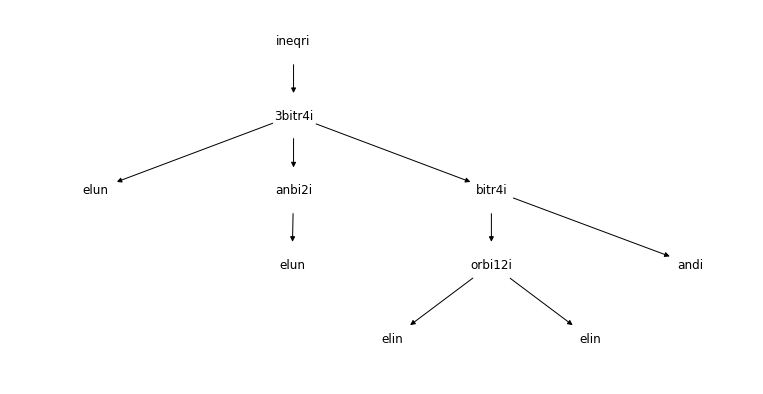

In [226]:
G, root = get_proof_graph("indi")

graph_nodes = list(nx.dfs_preorder_nodes(G, root, 9))
print len(graph_nodes)


graph_nodes_labels = {n:n.name for n in graph_nodes}

#graph_nodes_labels = {n: " ".join(database.propositions[n.name].statement) for n in graph_nodes}


plt.figure(figsize=(10, 5))
pos = graphviz_layout(G.subgraph(graph_nodes), prog="dot")#twopi
nx.draw(G.subgraph(graph_nodes), pos, labels=graph_nodes_labels, node_color="w", node_size=2000)
plt.show()

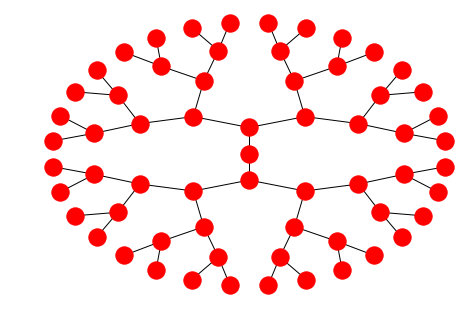

In [203]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 5)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos)
plt.show()

In [24]:
import d3fdgraph

def print_subgraph(edges_list, max_n_edges=100, node_radius=10):
    edges_df = pd.DataFrame(columns=["source", "target"], data=list(edges_list)[:max_n_edges])
    edges_df["weight"] = 1
    d3fdgraph.plot_force_directed_graph(edges_df, node_radius=node_radius)
    
def join_edges_list(*nodes_list):
    edges_list = list()
    for n in nodes_list:
        edges_list += list(G.edges(n))
    return edges_list

def flatten_edges_list(edges):
    l = list()
    for e in edges:
        l += list(e)
    return list(set(l))

ImportError: No module named d3fdgraph

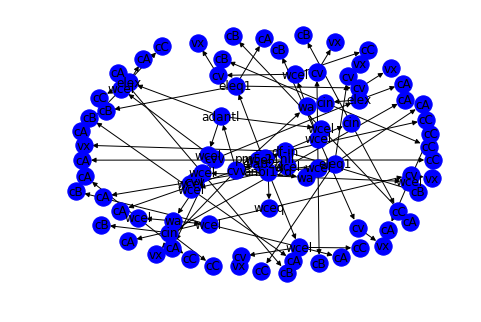

In [23]:
plot_graph(G)

In [34]:
pickle.dump(theorem_list, open("theorem_data.pkl", "wb"), protocol=2)

In [333]:
theorem_list[10].evaluate()

'|- ( ch -> ps )'

In [334]:
theorem_list[-1].label

'com45'

In [335]:
theorem_list[-1].evaluate()

'|- ( ph -> ( ps -> ( ch -> ( ta -> ( th -> wet ) ) ) ) )'

In [337]:
" ".join(theorem_list[-1]._prop.statement)

'|- ( ph -> ( ps -> ( ch -> ( ta -> ( th -> et ) ) ) ) )'

In [318]:
theorem_list[-1].output_tree

wi_wi

In [324]:
theorem_list[-1].variables

[wph_wph, wps_wps, wch_wch, wth_wth]

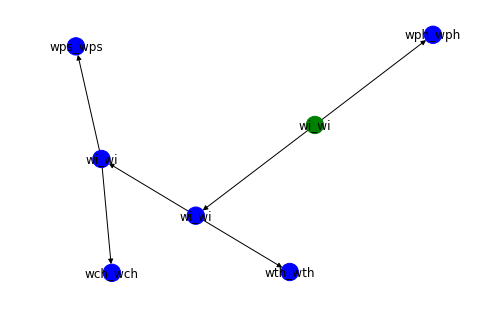

In [321]:
theorem_list[-1].plot()

In [114]:
statement_dict['a1i'].variables

[wph_wph, wps_wps]

In [ ]:
TUDO QUE TEM A MESMA VARIAVEL PRECISA COMPARTILHAR A MESMA REFERENCIA, NAO SO O QUE SUBSTITUI DIRETAMENTE, VER TEOREMA A1I

In [1746]:
statement_dict['a1i']._prop.hyps

[<f_hypothesis wph: wff ph>,
 <f_hypothesis wps: wff ps>,
 <e_hypothesis a1i.1: |- |-ph>]

In [1741]:
statement_dict['a1i'].input_trees

[a1i.1_wph]

In [1743]:
G[statement_dict['a1i'].output_tree]

AdjacencyView({ax-1_wph: {0: {'position': 1}}, ax-1_wps: {0: {'position': 0}}})

In [1663]:
str(statement_dict['a1i.1'].output_tree)

'a1i.1_wph'

In [1669]:
G[statement_dict['a1i.1'].output_tree]

AdjacencyView({})

In [1668]:
sorted(G.nodes, key=str)[0] == statement_dict['a1i.1'].output_tree

True

In [1648]:
last_prop.statement

['|-', '(', 'ch', '->', 'ps', ')']

In [1647]:
theorem_list[-1].evaluate()

'|- ( ps -> ps )'

In [ ]:
dl = database.propositions_list[10]
print dl.label
print " ".join(dl.statement)
print dl.type
print dl.hyps
print dl.proof

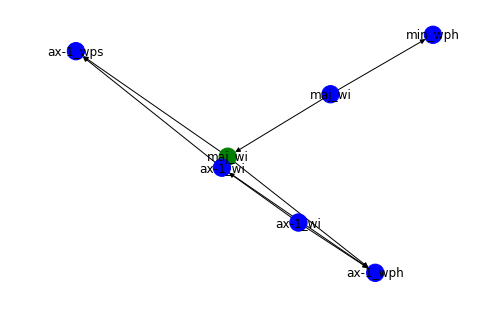

In [1639]:
theorem_list[-1].plot(True)

In [15]:
statement_dict['a1i'].input_trees

KeyError: 'a1i'

In [1619]:
dl_prop = prop_to_prop(dl)
dl_prop.verify()

[]
[]
[]
[]
[]
[<Hypotheses: mp1i.a>]
[<Hypotheses: mp1i.a>, <Hypotheses: mp1i.b>]
[<Axiom: ax-mp>]


False

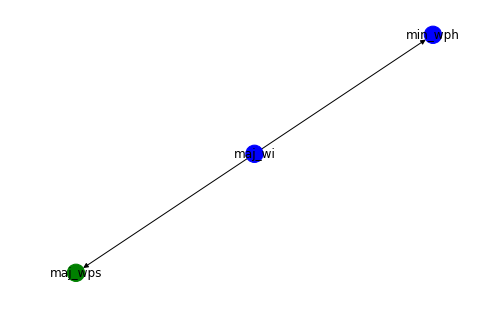

In [1624]:
dl_prop.plot(True)

In [1621]:
dl.statement

['|-', '(', 'ch', '->', 'ps', ')']

In [1489]:
h1 = statement_dict['mp2b.1']
h2 = statement_dict['mp2b.2']
axmp = statement_dict['ax-mp']

In [14]:
def get_leaves(node):

    node_leaves = list()
    for n in nx.dfs_preorder_nodes(G, node):
        try:
            if G.out_degree(n) == 0:
                node_leaves.append(n)
        except Exception as e:
            print n, G[n]
            raise e

    return node_leaves

def get_path(source, target):
    return nx.shortest_path(G, source, target)

def get_path_positions(path):
    positions = list()
    for i in range(len(path) - 1):
        s = path[i]
        t = path[i+1]
        pos = G.get_edge_data(s,t)[0]["position"]
        positions.append(pos)
        
    return positions

def get_node_leaves_paths(node):
    leaves_paths = list()
    
    node_leaves = get_leaves(node)
    for n in node_leaves:
        path = get_path(node, n)
        path_positions = get_path_positions(path)

        leaves_paths.append((n,path_positions))
    
    return leaves_paths

def walk_edges(source, positions):
    next_node = source
    
    for p in positions:
        for t, d in G[next_node].items():
            current_pos = d[0]['position']
            if current_pos == p:
                next_node = t
            
    return next_node

def get_analogous_nodes(node1, node2):
    """This function return a list of tuple leaf nodes that share the same topological places in their graphs."""
    analogous_nodes = list()
    
    node1_leaves_paths = get_node_leaves_paths(node1)
    for n1_leaf, n1_leaf_path in node1_leaves_paths:
        n1_anag = walk_edges(node2, n1_leaf_path)
        analogous_nodes.append((n1_leaf, n1_anag))
    
    return analogous_nodes


ax8_node_leaves = get_node_leaves_paths(ax8.output_tree)
assert walk_edges(ax8_node_leaves[2][0], ax8_node_leaves[2][1]) == ax8_node_leaves[2][0]

for n1, n2 in get_analogous_nodes(ax8.output_tree, ax8.output_tree):
    assert n1 == n2

NameError: name 'ax8' is not defined

In [1555]:
get_analogous_nodes(axmp.input_trees[1], axmp.input_trees[1])

[(maj_wps, maj_wps), (min_wph, min_wph)]

In [1526]:
for p in positions

for t, d in G[axmp.input_trees[1]].items():
    print t, d

maj_wps {0: {'position': 1}}
min_wph {0: {'position': 0}}


In [1522]:
axmp.input_trees[1]

maj_wi

In [1500]:
ax8_path

[ax-8_wi, ax-8_wceq, ax-8_cv, ax-8_vx]

In [1491]:
axmp.input_trees[1]

maj_wi

In [ ]:
def get_connected_componenets

In [1460]:
list(nx.kosaraju_strongly_connected_components(G, axmp.input_trees[1]))[0]

{min_wph, maj_wi, maj_wps}

In [1473]:
nx.shortest_path(G, axmp.input_trees[1], n_leaves[0])

[maj_wi, maj_wps]

In [1479]:
ax8 = statement_dict['ax-8']

In [1483]:
ax8.output_tree

ax-8_wi

In [1485]:
for s,t in nx.dfs_edges(G, ax8.output_tree):
    print s,t,G.get_edge_data(s,t)

ax-8_wi ax-8_wceq {0: {'position': 0}}
ax-8_wceq ax-8_cv {0: {'position': 0}}
ax-8_cv ax-8_vx {0: {'position': 0}}
ax-8_wceq ax-8_cv {0: {'position': 1}}
ax-8_cv ax-8_vy {0: {'position': 0}}
ax-8_wi ax-8_wi {0: {'position': 1}}
ax-8_wi ax-8_wceq {0: {'position': 1}}
ax-8_wceq ax-8_cv {0: {'position': 1}}
ax-8_cv ax-8_vz {0: {'position': 0}}
ax-8_wi ax-8_wceq {0: {'position': 0}}


[maj_wps, min_wph]

In [1462]:
G.out_degree(axmp.input_trees[1])

2

In [1459]:
axmp.input_trees[1]

maj_wi

In [1454]:
G[axmp.input_trees[1]]

AdjacencyView({maj_wps: {0: {'position': 1}}, min_wph: {0: {'position': 0}}})

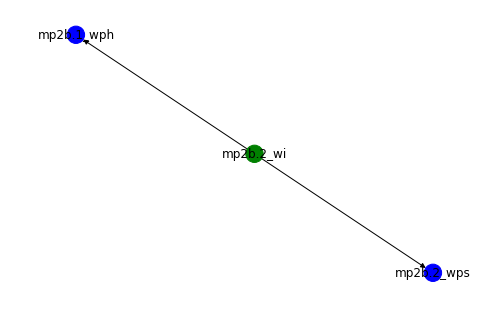

In [1448]:
h2.plot()

In [ ]:
#Need to get the leaves and find the same leaves in the stack expressions

In [1397]:
dl_prop.input_trees[0] == dl_prop.output_tree

True

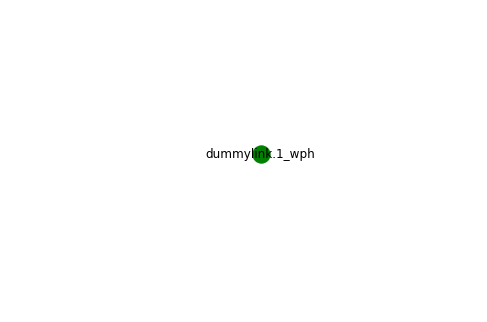

In [1401]:
dl_prop.plot(True)

In [1402]:
dl_prop.input_trees[0] == dl_prop.output_tree

True

In [1404]:
statement_dict["dummylink.1"]

<Hypotheses: dummylink.1>

In [1252]:
sg = get_connect_subgraph(statement_dict["ax-mp"].output_tree)

In [1249]:
list(sg.edges)[0] == list(sg.copy().edges)[0]

True

In [ ]:
def deep_copy_graph(g):
    

In [1251]:
sg.copy().edges

OutMultiEdgeView([(maj_wi, maj_wps, 0), (maj_wi, min_wph, 0)])

In [1275]:
memo = dict()
sgc = copy.deepcopy(sg, memo)

In [1295]:
list(sgc.nodes)[0] == statement_dict["ax-mp"].output_tree

False

In [1281]:
test1 = memo[id(statement_dict["ax-mp"].output_tree)]

In [1285]:
statement_dict["ax-mp"].output_tree

maj_wps

In [1287]:
test1

maj_wps

In [1296]:
sg[statement_dict["ax-mp"].output_tree]

AdjacencyView(FilterMultiInner({}, <networkx.classes.filters.show_nodes object at 0x0000000034A29188>, <function edge_ok at 0x00000000368D33C8>))

In [1297]:
sgcc = nx.compose(G, sgc)

In [1304]:
memo

{849544600L: {ax-5o_vx: {0: {'position': 1}}, ax-5o_wph: {0: {'position': 0}}},
 850127592L: {0: {'position': 0}},
 883392024L: {df-dif_wcel: {0: {'position': 1}},
  df-dif_cdif: {0: {'position': 0}}},
 899655608L: {},
 857341464L: {0: {'position': 0}},
 883019848L: {},
 882842344L: {'position': 1},
 882942728L: df-reu_vx,
 897640904L: ax-2_wi,
 854276840L: {ax-14_wi: {0: {'position': 1}}},
 882294856L: {ax-6o_wn: {0: {'position': 0}}},
 882310408L: {'symbol': 'ch', 'theorem': 'ax-meredith', 'value': 'wch'},
 841766024L: {0: {'position': 0}},
 896991304L: {'position': 1},
 861078664L: {ax-16_cv: {0: {'position': 0}}, ax-16_cv: {0: {'position': 1}}},
 816956824L: {ax-5_wi: {0: {'position': 1}}},
 882406536L: {'position': 0},
 884799688L: {'position': 0},
 855214824L: {},
 849574360L: {},
 883237208L: {0: {'position': 0}},
 853912296L: {0: {'position': 0}},
 883067624L: {df-clab_wb: {0: {'position': 0}}},
 883296456L: {},
 163520560L: 'ax-6o',
 861078392L: {'symbol': 'x', 'theorem': 'ax-